<a href="https://colab.research.google.com/github/son-n-pham/Bible-Study/blob/main/Son_Pham_lab05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CITS5508 labsheet 5

Sample code showing how to read the CIFAR-10 data. Only cells 1 and 2 are needed. **Note: For the code to work, all the data batch files should be in the same directory with this Notebook file.**

This is only an example. Students should put in their own markdown cells. 

Rather than looking at the code in the file **<i>data_loader.py</i>**, description about the `DataLoader` class in the file can be viewed using **<i>pydoc</i>**. Try typing the following command in a terminal window (assuming that *data_loader.py* is in the current directory):<br>
<tt>
&nbsp; &nbsp; pydoc data_loader
</tt>

To convert this file into **<i>lab05-sample.py</i>**, a Python script file, for running on **Kaya** (the UWA GPU computer), do the following:
* If you are using Jupyter-lab, then select **File $>$ Export Notebook As... $>$ Executable Script $>$**. In the popped up window, select **Save File** and click the **OK** button.
* If you are using **Jupyter-notebook**, then select **File $>$ Download as $>$ Python (.py)**. Note that the option **Python (.py)** might be hidden. You would need to scroll down the list to see it. In the popped up window, select **Save File** and click the **OK** button.

**Author: Du Huynh**<br>
**Date: April 2021**<br><br>

**Student: Son Pham**<br>
**Student ID: 23143675**<br>
**Date: May 2022**

I have use many GridSearchCV, HalvingGridSearchCV and various models for this lab, thus the Jupyter Notebook is quite long. Please use the table of content in Jupyter Note book to navigate it effectively. Thanks

#### Step 1: Import the `DataLoader` class

In [308]:
from data_loader import DataLoader

#### Step 2: Call the `load_batch` function

In [354]:
# According to the CIFAR-10 website, the training set is split into five batches
# stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There
# are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The default values of all the arguments of the load_batch function have been
# set for the CIFAR-10 dataset.
X_train, y_train = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

#### Step 3. A quick inspection of the outputs from the `load_batch` function

In [ ]:
# You need to split the training set to form a validation set. The original
# training set would become smaller.

In [310]:
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)
print('y_test.shape =', y_test.shape, 'data type:', y_test.dtype)

X_test.shape = (10000, 32, 32, 3) data type: float32
y_test.shape = (10000,) data type: uint8


In [311]:
RANDOM_STATE = 7

In [352]:
from sklearn.model_selection import train_test_split

import random
import numpy as np

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras import activations

# import joblib
import pickle
from time import time
from pathlib import Path
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

# from sklearn.ensemble import VotingRegressor
# from sklearn.svm import LinearSVR
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import SGDRegressor

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import BaggingRegressor

# from sklearn.metrics import mean_squared_error

# import matplotlib as mpl
import matplotlib.pyplot as plt

# plt.imshow(X_test[1], interpolation="nearest")
# print(y_test[1])

## Task 4
#### (i) Use an 85/15 random split on the training set to form a validation set. Use these training, validation, and test sets for training, validating, and testing both of your MLP and CNN models later on.

In [313]:
# Split training data to training and validating set
X_train, X_validate, y_train, y_validate = train_test_split(X_train,y_train,test_size=0.15, random_state=RANDOM_STATE)

#### (ii) Write a small function that takes in appropriate arguments so that it can be used to display 20 randomly sampled images from the arguments. This function should be called 3 times – for the training, validation, and test sets. The figure displayed by the function should show the corresponding class name of each image.

In [314]:
def plot_images(X_dataset, y_dataset, class_names, numbers_of_images=20):
    dataset_length = len(X_dataset)
    if dataset_length >= numbers_of_images:
        # Generate a list of random non-repeating index
        list_of_image_index = random.sample(range(dataset_length), numbers_of_images)
    else:
        # Just shuffle the image index
        list_of_image_index = random.sample(range(dataset_length), dataset_length)
    
    # Create figure
    fig = plt.figure(figsize=(10,10))
    
    # Setting numbers of columns and rows
    numbers_of_images = len(list_of_image_index)
    numbers_of_columns = 10
    numbers_of_rows = numbers_of_images//numbers_of_columns
    
    # fig, axs = plt.subplots(numbers_of_rows, numbers_of_columns)
    for index, image_index in enumerate(list_of_image_index):
        # Add a subplot
        fig.add_subplot(numbers_of_rows, numbers_of_columns, index+1)
        # Show image
        plt.imshow(X_dataset[image_index], interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_dataset[image_index]])
        
    plt.subplots_adjust(left=0,
                    bottom=0.01, 
                    right=1.2, 
                    top=0.2, 
                    wspace=0.2, 
                    hspace=0.5)
    plt.show()

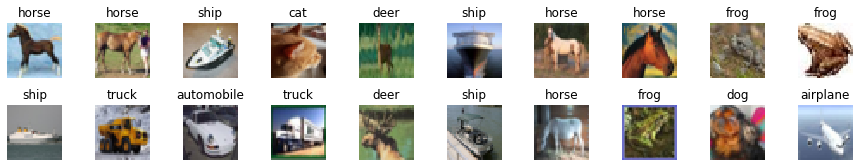

In [315]:
# Training set         
plot_images(X_train, y_train, class_names)

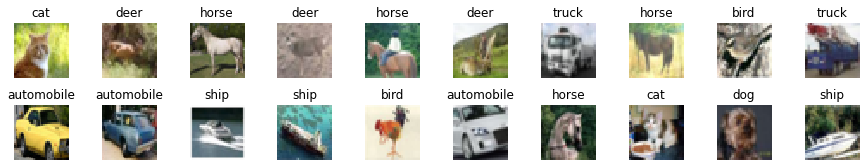

In [316]:
# Validing set         
plot_images(X_validate, y_validate, class_names)

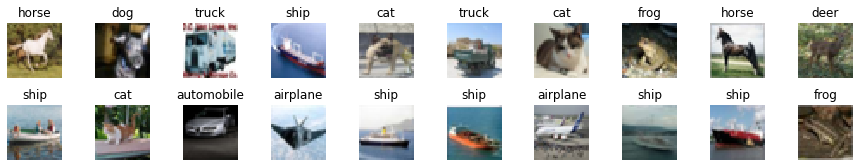

In [317]:
# Test set         
plot_images(X_test, y_test, class_names)

#### (iii) Implementation of an MLP

Design an MLP that has 2 to 3 hidden layers and an output layer. Use an appropriate function from
tensorflow.keras to show a summary of your MLP architecture.

You should try to design your MLP in such a way that the hidden layers have fewer neurons than
the input layer. This would help to avoid overfitting. You should train the network for 100 epochs
but use the validation set for early stopping (which also helps to overcome overfitting).
In each hidden layer, use a suitable number of neurons and an appropriate activation function.

Experiment with two possible settings for each of the following hyperparameters:

- connection weight initialisation;
- learning rate scheduling (you will need to use callback and write a small function for this);
- dropout rate.

You can use grid search together with the validation set created above to find the optimal value
for each of them. In the final version of your Notebook file, the code for this hyperparameter fine
tuning process should be moved to a markdown cell and explained there.

Your trained MLP model should be saved to the directory named Surname FirstName-MLP.

##### Quantify to identify the better Grid Search (GridSearchCV or HalvingGridSearchCV) and then utilize the better one for search the most suitable hyperparameters

- parameters for grid search is learning rate scheduler, drop rate and weight connection initialisation.
  - Step decay and time-based decay are selected as 2 options of learning rate scheduler.
  - Drop rates of 0.2 and 0.3 are tested.
  - Two options of weight connection are he_normal and glorot_normal

- GridSearchCV and HalvingGridSearchCV were used with 10 epochs to see which one is faster.
- The result is showing that HalvingGridSearchCV is faster than normal GridSearchCV, thus HalvingGridSearchCV is used to train with 100 epochs.
- The combination of initializer of he_normal and rate (of droprate) of 0.3 give the best result. Rate of 0.3 seems to reduce the overfitting as the score of test was close to the score of train.
- 3 helper functions were created to save the Grid Search and identiy the best parameters with their score.
- After running, cells of GridSearch was commented out to avoid running them again.

###### GridSearchCV with 10 epochs

The GridSearchCV needs 24minutes and 15seconds to complete 10 epochs

In [ ]:
# EPOCHS = 10
# BATCH_SIZE = 256

# # Learning Rate: Step decay 
# def piecewise_constant_fn(epoch):
#     if epoch < 5:
#         return 0.01
#     elif epoch < 15:
#         return 0.005
#     else:
#         return 0.001
# def piecewise_constant(boundaries, values):
#     boundaries = np.array([0] + boundaries)
#     values = np.array(values)
#     def piecewise_constant_fn(epoch):
#         return values[np.argmax(boundaries > epoch) - 1]
#     return piecewise_constant_fn
# piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])
# lr_scheduler_step = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

# # Learning Rate: Time-based decay
# initial_learning_rate = 0.01
# epochs = 100
# decay = initial_learning_rate / epochs
# def lr_time_based_decay(epoch, lr):
#     return lr * 1 / (1 + decay * epoch)
# lr_scheduler_time = keras.callbacks.LearningRateScheduler(lr_time_based_decay)

# # Dictionary of Learning Rate Schedulers
# lr_schedulers = {'lr_step_decay': lr_scheduler_step, 'lr_time-based_decay': lr_scheduler_time}

# # Using Callbacks to save checkpoint. This checkpoint callback is not used in GridSearchCV
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     "./Son_Pham-MLP/model",
#     verbose=0,
#     save_best_only=False,
#     save_weights_only=False,
#     mode="auto",
#     save_freq="epoch")

# # Early stopping
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# def create_model(kernel_initializer, rate):
#     model = keras.models.Sequential([    
#         keras.layers.Flatten(input_shape=[32, 32, 3]),
#         keras.layers.Dropout(rate=rate),
#         keras.layers.BatchNormalization(),
#         # use_bias is set to False as we have Batch Normalization
#         keras.layers.Dense(300, activation="elu", kernel_initializer=kernel_initializer, use_bias=False),
#         keras.layers.Dropout(rate=rate),
#         keras.layers.BatchNormalization(),
#         # use_bias is set to False as we have Batch Normalization
#         keras.layers.Dense(100, activation="elu", kernel_initializer=kernel_initializer, use_bias=False),
#         keras.layers.Dropout(rate=rate),
#         keras.layers.BatchNormalization(),
#         keras.layers.Dense(10, activation="softmax")
#     ])
#     model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
#     return model

# # create model
# model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, verbose=0, batch_size=BATCH_SIZE)

# # Parameters for GridSearchCV
# kernel_initializers = ["he_normal", "glorot_normal"]
# dropout_rates = [0.2, 0.3]
# param_grid = dict(kernel_initializer=kernel_initializers, rate=dropout_rates)

# grid = {}
# for lr_name, lr_scheduler in lr_schedulers.items():
#   print(f"======================={lr_name}====================")
#   callbacks = [early_stopping_cb, lr_scheduler]

#   grid[lr_name] = GridSearchCV(estimator=model, param_grid=param_grid, refit=True, cv=5, scoring="accuracy", verbose=3)

#   grid[lr_name].fit(X_train, y_train, callbacks=callbacks, validation_data=(X_validate, y_validate))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


=======================lr_step_decay====================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END kernel_initializer=he_normal, rate=0.2;, score=0.527 total time=  35.0s
[CV 2/5] END kernel_initializer=he_normal, rate=0.2;, score=0.535 total time=  34.4s
[CV 3/5] END kernel_initializer=he_normal, rate=0.2;, score=0.529 total time=  34.3s
[CV 4/5] END kernel_initializer=he_normal, rate=0.2;, score=0.535 total time=  33.9s
[CV 5/5] END kernel_initializer=he_normal, rate=0.2;, score=0.521 total time=  34.1s
[CV 1/5] END kernel_initializer=he_normal, rate=0.3;, score=0.513 total time=  33.9s
[CV 2/5] END kernel_initializer=he_normal, rate=0.3;, score=0.527 total time=  33.9s
[CV 3/5] END kernel_initializer=he_normal, rate=0.3;, score=0.522 total time=  33.9s
[CV 4/5] END kernel_initializer=he_normal, rate=0.3;, score=0.519 total time=  34.7s
[CV 5/5] END kernel_initializer=he_normal, rate=0.3;, score=0.510 total time=  34.2s
[CV 1/5] END kernel_initializer=g

###### HalvingGridSearchCV with 10 epochs

The HalvingGridSearchCV took 20minutes 40seconds to complete 10 epochs, which is faster than normal GridSearchCV

In [ ]:
# EPOCHS = 10
# BATCH_SIZE = 256

# # Learning Rate: Step decay 
# def piecewise_constant_fn(epoch):
#     if epoch < 5:
#         return 0.01
#     elif epoch < 15:
#         return 0.005
#     else:
#         return 0.001
# def piecewise_constant(boundaries, values):
#     boundaries = np.array([0] + boundaries)
#     values = np.array(values)
#     def piecewise_constant_fn(epoch):
#         return values[np.argmax(boundaries > epoch) - 1]
#     return piecewise_constant_fn
# piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])
# lr_scheduler_step = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

# # Learning Rate: Time-based decay
# initial_learning_rate = 0.01
# epochs = 100
# decay = initial_learning_rate / epochs
# def lr_time_based_decay(epoch, lr):
#     return lr * 1 / (1 + decay * epoch)
# lr_scheduler_time = keras.callbacks.LearningRateScheduler(lr_time_based_decay)

# # Dictionary of Learning Rate Schedulers
# lr_schedulers = {'lr_step_decay': lr_scheduler_step, 'lr_time-based_decay': lr_scheduler_time}

# # Using Callbacks to save checkpoint
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     "./Son_Pham-MLP/model",
#     verbose=0,
#     save_best_only=False,
#     save_weights_only=False,
#     mode="auto",
#     save_freq="epoch")

# # Early stopping
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# def create_model(kernel_initializer, rate):
#     model = keras.models.Sequential([    
#         keras.layers.Flatten(input_shape=[32, 32, 3]),
#         keras.layers.Dropout(rate=rate),
#         keras.layers.BatchNormalization(),
#         # use_bias is set to False as we have Batch Normalization
#         keras.layers.Dense(300, activation="elu", kernel_initializer=kernel_initializer, use_bias=False),
#         keras.layers.Dropout(rate=rate),
#         keras.layers.BatchNormalization(),
#         # use_bias is set to False as we have Batch Normalization
#         keras.layers.Dense(100, activation="elu", kernel_initializer=kernel_initializer, use_bias=False),
#         keras.layers.Dropout(rate=rate),
#         keras.layers.BatchNormalization(),
#         keras.layers.Dense(10, activation="softmax")
#     ])
#     model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
#     return model

# # create model
# model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, verbose=0, batch_size=BATCH_SIZE)

# # Parameters for GridSearchCV
# kernel_initializers = ["he_normal", "glorot_normal"]
# dropout_rates = [0.2, 0.3]
# param_grid = dict(kernel_initializer=kernel_initializers, rate=dropout_rates)

# halving_grid = {}
# for lr_name, lr_scheduler in lr_schedulers.items():
#   print(f"======================={lr_name}====================")
#   callbacks = [early_stopping_cb, lr_scheduler]

#   halving_grid[lr_name] = HalvingGridSearchCV(estimator=model, param_grid=param_grid, refit=True, cv=5, scoring="accuracy", verbose=3)

#   halving_grid[lr_name].fit(X_train, y_train, callbacks=callbacks, validation_data=(X_validate, y_validate))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


=======================lr_step_decay====================
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 14166
max_resources_: 42500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 14166
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END kernel_initializer=he_normal, rate=0.2;, score=(train=0.642, test=0.442) total time=  13.5s
[CV 2/5] END kernel_initializer=he_normal, rate=0.2;, score=(train=0.652, test=0.474) total time=  13.3s
[CV 3/5] END kernel_initializer=he_normal, rate=0.2;, score=(train=0.644, test=0.475) total time=  13.2s
[CV 4/5] END kernel_initializer=he_normal, rate=0.2;, score=(train=0.628, test=0.447) total time=  13.3s
[CV 5/5] END kernel_initializer=he_normal, rate=0.2;, score=(train=0.628, test=0.456) total time=  13.4s
[CV 1/5] END kernel_initializer=he_normal, rate=0.3;, score=(train=0.586, test=0.453) total time=  13.4s
[CV 2/5] END kernel_initializer=he_normal, rate=0

Because HalvingGridSearchCV was faster than GridSearchCV, HalvingGridSeachCV is selected to train with 100 epochs

In [ ]:
# EPOCHS = 100
# BATCH_SIZE = 256

# # Learning Rate: Step decay 
# def piecewise_constant_fn(epoch):
#     if epoch < 5:
#         return 0.01
#     elif epoch < 15:
#         return 0.005
#     else:
#         return 0.001
# def piecewise_constant(boundaries, values):
#     boundaries = np.array([0] + boundaries)
#     values = np.array(values)
#     def piecewise_constant_fn(epoch):
#         return values[np.argmax(boundaries > epoch) - 1]
#     return piecewise_constant_fn
# piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])
# lr_scheduler_step = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

# # Learning Rate: Time-based decay
# initial_learning_rate = 0.01
# epochs = 100
# decay = initial_learning_rate / epochs
# def lr_time_based_decay(epoch, lr):
#     return lr * 1 / (1 + decay * epoch)
# lr_scheduler_time = keras.callbacks.LearningRateScheduler(lr_time_based_decay)

# # Dictionary of Learning Rate Schedulers
# lr_schedulers = {'lr_step_decay': lr_scheduler_step, 'lr_time-based_decay': lr_scheduler_time}

# # Using Callbacks to save checkpoint
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     "./Son_Pham-MLP/model",
#     verbose=0,
#     save_best_only=False,
#     save_weights_only=False,
#     mode="auto",
#     save_freq="epoch")

# # Early stopping
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# def create_model(kernel_initializer, rate):
#     model = keras.models.Sequential([    
#         keras.layers.Flatten(input_shape=[32, 32, 3]),
#         keras.layers.Dropout(rate=rate),
#         keras.layers.BatchNormalization(),
#         # use_bias is set to False as we have Batch Normalization
#         keras.layers.Dense(300, activation="elu", kernel_initializer=kernel_initializer, use_bias=False),
#         keras.layers.Dropout(rate=rate),
#         keras.layers.BatchNormalization(),
#         # use_bias is set to False as we have Batch Normalization
#         keras.layers.Dense(100, activation="elu", kernel_initializer=kernel_initializer, use_bias=False),
#         keras.layers.Dropout(rate=rate),
#         keras.layers.BatchNormalization(),
#         keras.layers.Dense(10, activation="softmax")
#     ])
#     model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
#     return model

# # create model
# model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, verbose=0, batch_size=BATCH_SIZE)

# # Parameters for GridSearchCV
# kernel_initializers = ["he_normal", "glorot_normal"]
# dropout_rates = [0.2, 0.3]
# param_grid = dict(kernel_initializer=kernel_initializers, rate=dropout_rates)

# halving_grid = {}
# for lr_name, lr_scheduler in lr_schedulers.items():
#   print(f"======================={lr_name}====================")
#   callbacks = [early_stopping_cb, lr_scheduler]

#   halving_grid[lr_name] = HalvingGridSearchCV(estimator=model, param_grid=param_grid, refit=True, cv=5, scoring="accuracy", verbose=3)

#   halving_grid[lr_name].fit(X_train, y_train, callbacks=callbacks, validation_data=(X_validate, y_validate))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


=======================lr_step_decay====================
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 14166
max_resources_: 42500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 14166
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END kernel_initializer=he_normal, rate=0.2;, score=(train=0.628, test=0.463) total time=  19.6s
[CV 2/5] END kernel_initializer=he_normal, rate=0.2;, score=(train=0.630, test=0.465) total time=  18.2s
[CV 3/5] END kernel_initializer=he_normal, rate=0.2;, score=(train=0.674, test=0.460) total time=  20.0s
[CV 4/5] END kernel_initializer=he_normal, rate=0.2;, score=(train=0.657, test=0.453) total time=  21.9s
[CV 5/5] END kernel_initializer=he_normal, rate=0.2;, score=(train=0.603, test=0.456) total time=  15.5s
[CV 1/5] END kernel_initializer=he_normal, rate=0.3;, score=(train=0.706, test=0.494) total time=  42.3s
[CV 2/5] END kernel_initializer=he_normal, rate=0

###### Helpder functions for grid search dealing with learning rate scheduler in for loop

In [ ]:
def save_GridSearchCV(grid=grid, lr_name="lr_step_decay", dl_method="MLP"):
  """
  Helper function to save the result of GridSearchCV
  args:
    grid: grid search, which is either GridSearchCV or HalvingGridSearchCV
    lr_name: name of learning rate scheduler, which is eigher lr_step_decay or lr_time-based decay
    dl_method: deep learning method, which is either MLP or CNN
  return: no return
  """
  
  file_name = f"GridSearchCV_{dl_method}_{lr_name}.pkl"
  pickle.dump(grid[lr_name], open(file_name, 'wb'))

def grid_search_result(grid=grid, lr_name="lr_step_decay"):
  """
  Helper function to return the score of the best parameters for each learning rate scheduler
  arg:
    grid: grid search, which is either GridSearchCV or HalvingGridSearchCV 
    lr_name: which is either lr_step_decay or lr_time-based-decay
  return:
    mean_test_score_of_the_best_params: mean_test_score of the best parameters
    best_params: best_params
  """
  index_of_best_params = np.where(grid[lr_name].cv_results_['rank_test_score']==1)[0].item()
  mean_test_score_of_the_best_params = np.take(grid[lr_name].cv_results_['mean_test_score'], index_of_best_params)
  best_params = grid[lr_name].best_params_
  return mean_test_score_of_the_best_params, best_params

def identify_best_params(grid=grid, lr_schedulers=lr_schedulers):
  """
  Helper function to identify the best params including learning rate scheduler
  arg:
    grid: grid search, which is either GridSearchCV or HalvingGridSearchCV 
    lr_schedulers: dictionary of learning rate schedulers
  return:
    best_score: the best score from the best_params
    best_params: the best params which include kernel_initializer, rate(of drop rate) and lr_scheduler
  """
  best_score = 0
  best_params = ""
  best_lr_scheduler = ""
  for k,_ in lr_schedulers.items():
    score, params = grid_search_result(grid, k)
    if score>best_score:
      best_score = score
      best_params = params
      best_params['lr_scheduler'] = k
  return best_score, best_params

In [ ]:
# # Save HalvingGridSearchResult into the same folder and the Jupyter Notebook
# # As the GridSearch result file is not required to submitted, it is not included
# # in the submission package, but it is available to submit when being asked.
# for lr_name in ['lr_step_decay', 'lr_time-based_decay']:
#   save_GridSearchCV(grid=halving_grid, lr_name=lr_name, dl_method="MLP")

# # Best_score and its best params combination
# best_score, best_params = identify_best_params(grid=halving_grid, lr_schedulers=lr_schedulers)
# print(f'best_score is {best_score}')
# print(f'best_params is {best_params}')

INFO:tensorflow:Assets written to: ram://6ddfce18-7495-4659-88da-70d56df9ba60/assets
INFO:tensorflow:Assets written to: ram://1e664305-1e49-41ac-a106-5dfe4dc0da1a/assets
best_score is 0.5486527826803153
best_params is {'kernel_initializer': 'glorot_normal', 'rate': 0.3, 'lr_scheduler': 'lr_time-based_decay'}


##### Running MLP with best parameters and 100 epochs

###### Setup callbacks

In [318]:
def callbacks_config(folder):
  # Learning Rate: Step decay 
  def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 20:
        return 0.007
    elif epoch < 50:
        return 0.003
    else:
        return 0.001
  def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
      return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn
  piecewise_constant_fn = piecewise_constant([5, 20, 50], [0.01, 0.007, 0.003, 0.001])
  lr_scheduler_step = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

  # lr_step_decay is used as the learning rate scheduler
  lr_scheduler = lr_scheduler_step

  # Using Callbacks to save checkpoint of the best
  checkpoint_cb = keras.callbacks.ModelCheckpoint(
      "."/ Path(folder) / "best_model",
      verbose=1,
      save_best_only=True,
      monitor="val_accuracy",
      save_weights_only=False,
      mode="max",
      save_freq="epoch")

  # Early stopping
  early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

  # Compare to above GridSearch, checkpoint_cb is added to save the best one
  callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]
  return callbacks

###### MLP function

In [319]:
EPOCHS = 100

def MLP(epochs = EPOCHS, folder='Son_Pham-MLP'):
  """
  Function to run MLP with 100 epochs and save the model result
  """
  BATCH_SIZE = 256
  def create_model(kernel_initializer, rate):
    model = keras.models.Sequential([    
      keras.layers.Flatten(input_shape=[32, 32, 3]),
      keras.layers.Dropout(rate=rate),
      keras.layers.BatchNormalization(),
      # use_bias is set to False as we have Batch Normalization
      keras.layers.Dense(300, activation="elu", kernel_initializer=kernel_initializer, use_bias=False),
      keras.layers.Dropout(rate=rate),
      keras.layers.BatchNormalization(),
      # use_bias is set to False as we have Batch Normalization
      keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", use_bias=False),
      keras.layers.Dropout(rate=rate),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
    return model

  model = create_model(kernel_initializer="he_normal", rate=0.3)

  model.summary()

  start = time()
  model.fit(X_train, y_train, callbacks=callbacks_config(folder), epochs=epochs, 
            batch_size=BATCH_SIZE, validation_data=(X_validate, y_validate), 
            verbose=2)
  time_to_fit = time() - start
  print(f"Total time to train: {time_to_fit}")

  # Write time_to_fit to txt file
  # open the file in the write mode
  with open(Path(folder) / 'time_to_fit.txt', 'w') as f:
    # write to the opened file
    f.write(f"{time_to_fit}")

  # Save model
  model.save(filepath=Path(folder) / "model")

#### (iv) Implementation of a CNN

##### HalvingGridSearchCV

- From the above, HalvingGridSearchCV is faster than normal GridSearchCV, thus it is used to fine-tune hyperparameters for CNN.
- It took 5 hours to run this HalvingGridSearchCV, the best parameters afterward are: elu activation function, filter size of 3 and 96 filters.

In [ ]:
# EPOCHS = 100
# BATCH_SIZE = 256

# # Learning Rate: Step decay 
# def piecewise_constant_fn(epoch):
#     if epoch < 5:
#         return 0.01
#     elif epoch < 15:
#         return 0.005
#     else:
#         return 0.001
# def piecewise_constant(boundaries, values):
#     boundaries = np.array([0] + boundaries)
#     values = np.array(values)
#     def piecewise_constant_fn(epoch):
#         return values[np.argmax(boundaries > epoch) - 1]
#     return piecewise_constant_fn
# piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])
# lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)


# # Using Callbacks to save checkpoint
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     "./Son_Pham-MLP/model",
#     verbose=0,
#     save_best_only=False,
#     save_weights_only=False,
#     mode="auto",
#     save_freq="epoch")


# # Early stopping
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


# # callbacks: For GridSearchCV/HalvingGridSearchCV, I do not use callbacks' ModelCheckpoint
# callbacks = [early_stopping_cb, lr_scheduler]

# def create_model(kernels_number=64, kernel_size=3, activation=activations.relu):    
#     model = keras.models.Sequential()
#     model.add(keras.layers.Conv2D(32, kernel_size=kernel_size, padding="same", input_shape=(32,32,3)))
#     model.add(keras.layers.Activation(activation))
#     model.add(keras.layers.MaxPool2D((2,2)))
#     model.add(keras.layers.Conv2D(kernels_number, kernel_size=kernel_size, padding="same"))
#     model.add(keras.layers.Activation(activation))
#     model.add(keras.layers.MaxPool2D((2,2)))
#     model.add(keras.layers.Conv2D(kernels_number, kernel_size=kernel_size, padding="same"))
#     model.add(keras.layers.Activation(activation))
#     model.add(keras.layers.MaxPool2D((2,2)))
#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dropout(0.3))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False))
#     model.add(keras.layers.Activation(activation))
#     model.add(keras.layers.Dropout(0.3))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False))
#     model.add(keras.layers.Activation(activation))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.Dense(10, activation="softmax"))

#     model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
#     return model


# # Parameters for GridSearchCV
# kernel_size = [3, 5]
# kernels_number = [64, 96]
# activation = [activations.relu, activations.elu]
# param_grid = dict(kernel_size=kernel_size, kernels_number=kernels_number, activation=activation)

# model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, verbose=0, batch_size=BATCH_SIZE)
# halving_grid = HalvingGridSearchCV(estimator=model, param_grid=param_grid, refit=True, cv=5, scoring="accuracy", verbose=3)
# halving_grid.fit(X_train, y_train, callbacks=callbacks, validation_data=(X_validate, y_validate))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 14166
max_resources_: 42500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 14166
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END activation=<function relu at 0x7f856abee710>, kernel_size=3, kernels_number=64;, score=(train=0.603, test=0.524) total time= 1.8min
[CV 2/5] END activation=<function relu at 0x7f856abee710>, kernel_size=3, kernels_number=64;, score=(train=0.652, test=0.558) total time= 2.1min
[CV 3/5] END activation=<function relu at 0x7f856abee710>, kernel_size=3, kernels_number=64;, score=(train=0.887, test=0.661) total time= 3.6min
[CV 4/5] END activation=<function relu at 0x7f856abee710>, kernel_size=3, kernels_number=64;, score=(train=0.886, test=0.653) total time= 3.7min
[CV 5/5] END activation=<function relu at 0x7f856abee710>, kernel_size=3, kernels_number=64;, score=(train=0.643, test=0.596) total time= 2.4min
[CV 1/5] EN

HalvingGridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f854b46dad0>,
                    param_grid={'activation': [<function relu at 0x7f856abee710>,
                                               <function elu at 0x7f856abebe60>],
                                'kernel_size': [3, 5],
                                'kernels_number': [64, 96]},
                    scoring='accuracy', verbose=3)

In [ ]:
# halving_grid.best_params_

{'activation': <function keras.activations.elu>,
 'kernel_size': 3,
 'kernels_number': 96}

In [ ]:
# # Saving HalvingGridSearchCV
# file_name = f"HalvingGridSearchCV_CNN.pkl"
# pickle.dump(halving_grid, open(file_name, 'wb'))

INFO:tensorflow:Assets written to: ram://04c249b7-fbb4-482e-bc73-362f33ac0fdd/assets


##### CNN with best parameters derived from HalvingGridSearchCV

In [320]:
EPOCHS = 1
BATCH_SIZE = 256

def CNN(epochs=EPOCHS, folder="Son_Pham-CNN"):
  """
  Function to run CNN with given epochs
  """
  def create_model(kernels_number=64, kernel_size=3, activation=activations.relu):    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=kernel_size, padding="same", input_shape=(32,32,3)))
    model.add(keras.layers.Activation(activation))
    model.add(keras.layers.MaxPool2D((2,2)))
    # model.add(keras.layers.Conv2D(kernels_number, kernel_size=kernel_size, padding="same"))
    # model.add(keras.layers.Activation(activation))
    # model.add(keras.layers.MaxPool2D((2,2)))
    model.add(keras.layers.Conv2D(kernels_number, kernel_size=kernel_size, padding="same"))
    model.add(keras.layers.Activation(activation))
    model.add(keras.layers.MaxPool2D((2,2)))
    model.add(keras.layers.Flatten())
    # model.add(keras.layers.Dropout(0.3))
    # model.add(keras.layers.BatchNormalization())
    # model.add(keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False))
    # model.add(keras.layers.Activation(activation))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False))
    model.add(keras.layers.Activation(activation))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
    return model

  model = create_model(kernels_number=96, kernel_size=3, activation=activations.elu)

  start = time()
  model.fit(X_train, y_train, callbacks=callbacks_config(folder), 
            validation_data=(X_validate, y_validate), 
            epochs=epochs, batch_size=BATCH_SIZE, verbose=2)
  time_to_fit = time() - start
  print(f"Total time to train: {time_to_fit}")

  # Write time_to_fit to txt file
  # open the file in the write mode
  with open(Path(folder) / 'time_to_fit.txt', 'w') as f:
    # write to the opened file
    f.write(f"{time_to_fit}")

  # Save model
  model.save(filepath=Path(folder) / "model")

#### (v) Structure of your code

In [321]:
def get_train_model(deep_learning_method=MLP, 
                    model_path='./Son_Pham-MLP/best_model'):
  """
  Function as requirement from the lab.
  if the MLP model subdirectory is present in the current directory
    load the model,
    display its architecture,
    train for one epoch.
  else
    set up the model and display its architecture,
    train the model from scratch for 100 epochs using the optimal
  hyperparamter values.
    save the model to the directory described earlier.
  """

  try:
    # Load model
    model = tf.keras.models.load_model(model_path)
    # Summary of model
    print("Saved model exists.")
    model.summary()
    # Fit model with 1 epoch
    print("Train the saved model with 1epoch.")
    model.fit(X_train, y_train, 
              epochs=1, 
              validation_data=(X_validate, y_validate),
              verbose=2, batch_size=10)
    return model
  except OSError:
    # Run deep_learning_method when saved model does not exist
    print("Saved model does not exist. Model is setup and trained now with \
100epochs. Trained model will be saved. After training complete, \
this function is called again to load the saved model.")
    deep_learning_method(100)
    # Recall get_train_model again to load the saved model
    get_train_model(deep_learning_method, model_path)

In [ ]:
model_MLP = get_train_model(deep_learning_method=MLP,
                        model_path='./Son_Pham-MLP/best_model')

Saved model does not exist. Model is setup and trained now with 100epochs. Trained model will be saved. After training complete, this function is called again to load the saved model.
Model: "sequential_524"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_524 (Flatten)       (None, 3072)              0         
                                                                 
 dropout_1500 (Dropout)      (None, 3072)              0         
                                                                 
 batch_normalization_1569 (B  (None, 3072)             12288     
 atchNormalization)                                              
                                                                 
 dense_1569 (Dense)          (None, 300)               921600    
                                                                 
 dropout_1501 (Dropout)      (None, 300)               0         


In [ ]:
model_CNN = get_train_model(deep_learning_method=CNN,
                        model_path='./Son_Pham-CNN/best_model')

Saved model does not exist. Model is setup and trained now with 100epochs. Trained model will be saved. After training complete, this function is called again to load the saved model.
Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.11840, saving model to Son_Pham-CNN/best_model
INFO:tensorflow:Assets written to: Son_Pham-CNN/best_model/assets
167/167 - 36s - loss: 1.3804 - accuracy: 0.5162 - val_loss: 7.5147 - val_accuracy: 0.1184 - lr: 0.0100 - 36s/epoch - 214ms/step
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.11840 to 0.12333, saving model to Son_Pham-CNN/best_model
INFO:tensorflow:Assets written to: Son_Pham-CNN/best_model/assets
167/167 - 34s - loss: 1.0630 - accuracy: 0.6271 - val_loss: 14.0265 - val_accuracy: 0.1233 - lr: 0.0100 - 34s/epoch - 206ms/step
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.12333 to 0.22707, saving model to Son_Pham-CNN/best_model
INFO:tensorflow:Assets written to: Son_Pham-CNN/best_model/assets
167/167 - 34s - loss: 0.9

##### Observation
- MLP has less time per epoch compared to CNN.
- Although with less epochs, CNN can reach much higher accuracy compared to MLP.
- CNN has less parameters, including trainable parameters compared to MLP.
- However, unstable accuracy of validation set (val_accuracy) is observed. I thought it is due to overfitting from CNN model, thus I started commenting out a layer of Conv2D and Dense to have the current model. The unstability of val_accuracy seems to be improved slightly, but the accuracy seems not to be affected negatively. This is still unknown to me, thus it would be great if the lecturer gives some insight of the reason. Thanks very much. 

### (vi) Compare and comment on MLP and CNN performances:
The below will be quantified and discussed
- Accuracy, F1 score, precision per class
- Model complexity
- Computation time

In [322]:
# Loading the best model of the saved MLP model
MLP = get_train_model(deep_learning_method=MLP,
                        model_path='./Son_Pham-MLP/best_model')

Saved model exists.
Model: "sequential_524"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_524 (Flatten)       (None, 3072)              0         
                                                                 
 dropout_1500 (Dropout)      (None, 3072)              0         
                                                                 
 batch_normalization_1569 (B  (None, 3072)             12288     
 atchNormalization)                                              
                                                                 
 dense_1569 (Dense)          (None, 300)               921600    
                                                                 
 dropout_1501 (Dropout)      (None, 300)               0         
                                                                 
 batch_normalization_1570 (B  (None, 300)              1200      
 atchNormalization)             

In [323]:
# Loading the best model of the saved CNN model
CNN = get_train_model(deep_learning_method=CNN,
                        model_path='./Son_Pham-CNN/best_model')

Saved model exists.
Model: "sequential_525"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_205 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 activation_340 (Activation)  (None, 32, 32, 32)       0         
                                                                 
 max_pooling2d_205 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_206 (Conv2D)         (None, 16, 16, 96)        27744     
                                                                 
 activation_341 (Activation)  (None, 16, 16, 96)       0         
                                                                 
 max_pooling2d_206 (MaxPooli  (None, 8, 8, 96)         0         
 ng2D)                          

#### Accuracy, F1 score, precision per class
- We can find the below for accuracy, F1 score and precision per class for both MLP and CNN.
- Overally, CNN has higher precision, f1-score and accuracy
- MLP is struggling to handle some particular class, ie. class 3 (cat)
- Confusion matrix is not required in this lab; however, it is always good to have the confusion matrix with heatmap to identify where we can improve the performance of the model further. For CNN, I would spend more time to understand why the model has the high risk mis-classed automobile with truck to improve it further.

##### MLP

In [364]:
MLP_metrics = classification_report(y_true=y_test, 
                              y_pred=MLP.predict(X_test).argmax(axis=-1))
print(MLP_metrics)

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      1000
           1       0.63      0.71      0.67      1000
           2       0.48      0.25      0.33      1000
           3       0.37      0.22      0.27      1000
           4       0.40      0.56      0.47      1000
           5       0.41      0.54      0.46      1000
           6       0.51      0.65      0.57      1000
           7       0.63      0.58      0.61      1000
           8       0.63      0.66      0.65      1000
           9       0.64      0.56      0.60      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.52     10000
weighted avg       0.53      0.53      0.52     10000



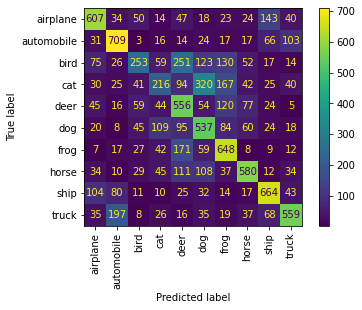

In [362]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
ConfusionMatrixDisplay.from_predictions(y_test, MLP.predict(X_test).argmax(axis=-1), display_labels=np.array(class_names))
plt.xticks(rotation=90)
plt.show()

##### CNN

In [366]:
CNN_metrics = classification_report(y_true=y_test, 
                              y_pred=CNN.predict(X_test).argmax(axis=-1))
print(CNN_metrics)

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1000
           1       0.89      0.67      0.76      1000
           2       0.55      0.57      0.56      1000
           3       0.59      0.40      0.48      1000
           4       0.60      0.72      0.66      1000
           5       0.68      0.48      0.56      1000
           6       0.73      0.83      0.78      1000
           7       0.71      0.78      0.74      1000
           8       0.76      0.81      0.79      1000
           9       0.67      0.84      0.75      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.68     10000
weighted avg       0.69      0.69      0.68     10000



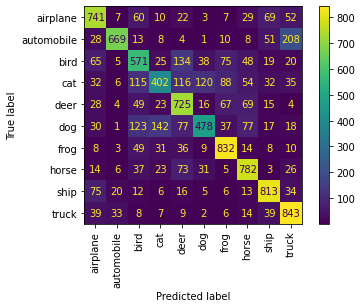

In [367]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
ConfusionMatrixDisplay.from_predictions(y_test, CNN.predict(X_test).argmax(axis=-1), display_labels=np.array(class_names))
plt.xticks(rotation=90)
plt.show()

#### Model complexity

- CNN has more layers but ~30% less trainable params than MLP

In [369]:
MLP.summary()

Model: "sequential_524"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_524 (Flatten)       (None, 3072)              0         
                                                                 
 dropout_1500 (Dropout)      (None, 3072)              0         
                                                                 
 batch_normalization_1569 (B  (None, 3072)             12288     
 atchNormalization)                                              
                                                                 
 dense_1569 (Dense)          (None, 300)               921600    
                                                                 
 dropout_1501 (Dropout)      (None, 300)               0         
                                                                 
 batch_normalization_1570 (B  (None, 300)              1200      
 atchNormalization)                                 

In [370]:
CNN.summary()

Model: "sequential_525"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_205 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 activation_340 (Activation)  (None, 32, 32, 32)       0         
                                                                 
 max_pooling2d_205 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_206 (Conv2D)         (None, 16, 16, 96)        27744     
                                                                 
 activation_341 (Activation)  (None, 16, 16, 96)       0         
                                                                 
 max_pooling2d_206 (MaxPooli  (None, 8, 8, 96)         0         
 ng2D)                                              

In [377]:
from keras.utils.layer_utils import count_params

MLP_trainable_params = count_params(MLP.trainable_weights)
MLP_non_trainable_params = count_params(MLP.non_trainable_weights)
CNN_trainable_params = count_params(CNN.trainable_weights)
CNN_non_trainable_params = count_params(CNN.non_trainable_weights)

In [386]:
print(f"CNN has {round(((MLP_trainable_params - CNN_trainable_params)/MLP_trainable_params*100),0)}% less trainable parameters than MLP")

CNN has 32.0% less trainable parameters than MLP


#### Computation time
- CNN needed less epochs of training to achieve higher accuracy than MLP
- CNN needed more time to train each epoch
- CNN also needed more time for prediction

##### Training time

In [391]:
file = "./Son_Pham-MLP/time_to_fit.txt"
with open(file, "r") as f:
  training_time_MLP = float(f.readline())
training_time_per_epoch_MLP = training_time_MLP / 100
print(f"Total training time of MLP is: {training_time_MLP}s")
print(f"Averaged training time per epoch of MLP is: {training_time_per_epoch_MLP}s")


print("======================")

file = "./Son_Pham-CNN/time_to_fit.txt"
with open(file, "r") as f:
  training_time_CNN = float(f.readline())
training_time_per_epoch_CNN = training_time_CNN / 40
print(f"Total training time of CNN is: {training_time_CNN}s")
print(f"Averaged training time per epoch of CNN is: {training_time_per_epoch_CNN}s")

Total training time of MLP is: 439.59054470062256s
Averaged training time per epoch of MLP is: 4.395905447006226s
Total training time of CNN is: 1330.6679921150208s
Averaged training time per epoch of CNN is: 33.26669980287552s


##### Prediction time

In [395]:
start = time()
MLP.predict(X_test)
durable = time()-start
print(f"MLP needed {durable}s to predict from the test set")

print("===========================")

start = time()
CNN.predict(X_test)
durable = time()-start
print(f"CNN needed {durable}s to predict from the test set")

MLP needed 1.3558638095855713s to predict from the test set
CNN needed 2.5230796337127686s to predict from the test set


##### Display images

In [397]:
y_pred_CNN = CNN.predict(X_test).argmax(axis=-1)
print(y_pred_CNN)

[3 8 0 ... 5 0 7]


In [401]:
def prediction_result(X_test, y_test, model):
  y_pred = model.predict(X_test).argmax(axis=-1)
  X_correct = []
  y_correct = []
  X_incorrect = []
  y_incorrect = []
  for k,v in enumerate(y_test):
    if v == y_pred[k]:
      X_correct.append(X_test[k])
      y_correct.append(v)
    else:
      X_incorrect.append(X_test[k])
      y_incorrect.append(v)
  return X_correct, y_correct, X_incorrect, y_incorrect

X_correct_MLP, y_correct_MLP, X_incorrect_MLP, y_incorrect_MLP = prediction_result(X_test, y_test, MLP)
X_correct_CNN, y_correct_CNN, X_incorrect_CNN, y_incorrect_CNN = prediction_result(X_test, y_test, CNN)

Correct Prediction from MLP:


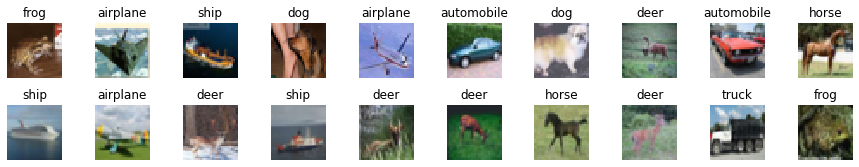

Incorrect Prediction from MLP:


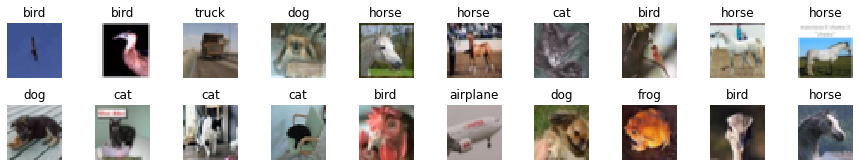

In [403]:
print("Correct Prediction from MLP:")
plot_images(X_correct_MLP, y_correct_MLP, class_names)

print("=============================")

print("Incorrect Prediction from MLP:")
plot_images(X_incorrect_MLP, y_incorrect_MLP, class_names)

Correct Prediction from CNN:


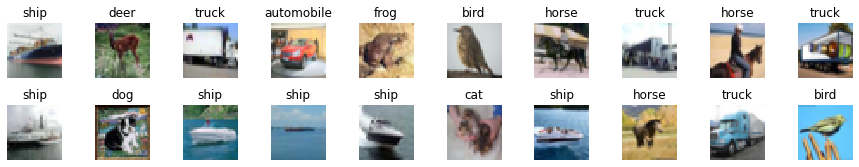

Incorrect Prediction from CNN:


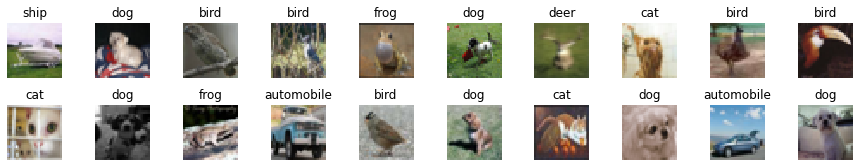

In [404]:
print("Correct Prediction from CNN:")
plot_images(X_correct_CNN, y_correct_CNN, class_names)

print("=============================")

print("Incorrect Prediction from CNN:")
plot_images(X_incorrect_CNN, y_incorrect_CNN, class_names)